# Problem Understanding

- **Robot Arms Configuration**

  - Two opposing robot arms.
  - A metal sheet sandwiched between rounded end effectors.
  - Distinct roles for each arm:
    - One arm/end effector for indenting the metal.
    - The other arm provides backing support.
  - Both end effectors follow similar trajectories.

# Assumptions and Decisions

- **Model Objective**
  - Aim: Develop a model to predict forces on both end effectors prior to execution.
  - Purpose: Facilitate motion planning.

- **Basis of Assumption**
  - The decision is influenced by the low sample frequency (1 Hz).
  - This frequency is considered low relative to the arms' potential for high control input and force feedback frequency.

- **Force Dynamics**
  - The pushing end effector is assumed to experience larger forces than the backing end effector.

- **Data Handling**
  - Allocation of Test Data:
    - Test1: Used for training.
    - Test2: Designated for validation.
    - Test3: Employed for testing purposes.


In [1]:
!pip install opencv-python pandas numpy keras-tuner tensorflow scikit-learn seaborn matplotlib xgboost


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [9]:
# Data handling and numerical processing
import pandas as pd
import numpy as np

# Machine learning and neural network models
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam  # Uncomment for M1/M2 Mac optimization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

# Hyperparameter tuning
from keras_tuner import Hyperband


# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical computations
from scipy import stats

#Other
import os

In [3]:
#Load files to dataframes:

def load_csv_to_dataframe(filename):
    return pd.read_csv(filename)


df_train = load_csv_to_dataframe("Test1.csv")
df_validation = load_csv_to_dataframe("Test2.csv")
df_test = load_csv_to_dataframe("Test4.csv")

dataframes = [df_train, df_validation, df_test] # List of your DataFrames


In [68]:

#Exploratory Data Analysis:

# Create directories for EDA plots and summaries
eda_plots_dir = "eda_plots"
summaries_dir = "eda_summaries"
os.makedirs(eda_plots_dir, exist_ok=True)
os.makedirs(summaries_dir, exist_ok=True)

# Sample size for large datasets (adjust as needed)
sample_size = 1000

# Exploratory Data Analysis
for i, df in enumerate(dataframes, start=1):

    # If the dataframe is large, sample it
    if len(df) > sample_size:
        df_sampled = df.sample(n=sample_size, random_state=42)
    else:
        df_sampled = df

    # Histograms for all numerical features
    hist_file = os.path.join(eda_plots_dir, f"histogram_df{i}.png")
    df_sampled.hist(figsize=(12, 8))  # Adjust figsize as needed
    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust the spacing
    plt.savefig(hist_file)
    plt.close()

    # Time Series Plots for each column
    for column in df_sampled.columns:
        if column != 't': 
            plt.figure()
            plt.plot(df_sampled['t'], df_sampled[column])
            plt.xlabel('Time (t)')
            plt.ylabel(column)
            plt.title(f'{column} over Time')
            time_series_file = os.path.join(eda_plots_dir, f"time_series_{column}_df{i}.png")
            plt.savefig(time_series_file)
            plt.close()

    # Save summary statistics
    summary_stats_file = os.path.join(summaries_dir, f"summary_stats_df{i}.txt")
    with open(summary_stats_file, 'w') as file:
        file.write(f"DataFrame {i} Summary Statistics:\n")
        file.write(df_sampled.describe().to_string())

    print(f"Plots and summary statistics saved for DataFrame {i}.")


    print(f"Plots saved for DataFrame {i} in '{eda_plots_dir}' folder.")



Plots and summary statistics saved for DataFrame 1.
Plots saved for DataFrame 1 in 'eda_plots' folder.
Plots and summary statistics saved for DataFrame 2.
Plots saved for DataFrame 2 in 'eda_plots' folder.
Plots and summary statistics saved for DataFrame 3.
Plots saved for DataFrame 3 in 'eda_plots' folder.


In [4]:
#Helper functions for feature engineering:
def angular_difference(df, angle1, angle2):
    return np.abs(df[angle1] - df[angle2])

def vector_difference(df, coord1, coord2):
    return df[coord1] - df[coord2]

def cosine_similarity(df, angle1, angle2):
    return np.cos(np.radians(df[angle1] - df[angle2]))

def calculate_speed(df, coord, time='t'):
    return df[coord].diff() / df[time].diff()

def calculate_angular_change_rate(df, angle, time='t'):
    return df[angle].diff() / df[time].diff()

def calculate_tot_dist_change(df, coord, time="t"):
    return df[coord].diff()/df[time].diff()

def adjusted_angular_difference(df, angle1, angle2):
    # Calculate absolute difference
    diff = np.abs(df[angle1] - df[angle2])

    # Adjust the difference
    # If the difference is more than 180 degrees, subtract it from 360 to find the 'opposite' difference
    adjusted_diff = np.where(diff > 180, 360 - diff, diff)

    # Since we want 0 to represent directly opposite, subtract each difference from 180
    # This makes 0 degrees represent opposite angles and 180 degrees represent the same direction
    return 180 - adjusted_diff

def angle_to_vector(df, angle):
    # Assuming 'angle' is in degrees and represents a direction in 2D space
    return np.cos(np.radians(df[angle])), np.sin(np.radians(df[angle]))

def angle_between_vectors1(df, angle1, angle2):
    # Convert angles to vectors
    vec1_x, vec1_y = angle_to_vector(df, angle1)
    vec2_x, vec2_y = angle_to_vector(df, angle2)

    # Normalize the vectors
    norm1 = np.sqrt(vec1_x**2 + vec1_y**2)
    norm2 = np.sqrt(vec2_x**2 + vec2_y**2)

    # Calculate dot product
    dot_product = (vec1_x * vec2_x + vec1_y * vec2_y) / (norm1 * norm2)

    # Calculate the angle in radians between vectors
    angle = np.arccos(np.clip(dot_product, -1.0, 1.0))  # clip for numerical stability

    # Convert angle to degrees
    return np.degrees(angle)


def euler_to_direction_vector(df, angle_a, angle_b, angle_c):
    # Assuming angles are in degrees and represent rotations in 3D space
    # Convert Euler angles to direction vectors (simplified for demonstration)
    return np.cos(np.radians(df[angle_a])), np.sin(np.radians(df[angle_b])), np.sin(np.radians(df[angle_c]))

def calculate_relative_position_vector(df, x1, y1, z1, x2, y2, z2):
    return df[x2] - df[x1], df[y2] - df[y1], df[z2] - df[z1]

def angle_between_vectors(vec1, vec2):
    # Normalize the vectors
    norm1 = np.sqrt(np.sum(np.square(vec1), axis=1))
    norm2 = np.sqrt(np.sum(np.square(vec2), axis=1))

    # Calculate dot product and angle
    dot_product = np.einsum('ij,ij->i', vec1, vec2) / (norm1 * norm2)
    angle = np.arccos(np.clip(dot_product, -1.0, 1.0))  # Clip for numerical stability

    # Convert to degrees
    return np.degrees(angle)

def euler_to_direction_vector(df, angle_a, angle_b, angle_c):
    # Convert Euler angles to direction vectors
    return np.cos(np.radians(df[angle_a])), np.sin(np.radians(df[angle_b])), np.sin(np.radians(df[angle_c]))

def calculate_position_vector(df, x1, y1, z1, x2, y2, z2):
    return df[x2] - df[x1], df[y2] - df[y1], df[z2] - df[z1]

def angle_between_vectors2(vec1, vec2):
    # Normalize the vectors
    norm1 = np.sqrt(np.sum(np.square(vec1), axis=1))
    norm2 = np.sqrt(np.sum(np.square(vec2), axis=1))

    # Calculate dot product and angle
    dot_product = np.einsum('ij,ij->i', vec1, vec2) / (norm1 * norm2)
    angle = np.arccos(np.clip(dot_product, -1.0, 1.0))  # Clip for numerical stability

    # Convert to degrees
    return np.degrees(angle)




In [5]:
#Add engineered feature columns to dfs:
for df in dataframes:

    df['cos_a_1'] = np.cos(np.radians(df['a_enc_1']))
    df['cos_b_1'] = np.cos(np.radians(df['b_enc_1']))
    df['cos_c_1'] = np.cos(np.radians(df['c_enc_1']))
    df['cos_a_2'] = np.cos(np.radians(df['a_enc_2']))
    df['cos_b_2'] = np.cos(np.radians(df['b_enc_2']))
    df['cos_c_2'] = np.cos(np.radians(df['c_enc_2']))

    df['sin_a_1'] = np.sin(np.radians(df['a_enc_1']))
    df['sin_b_1'] = np.sin(np.radians(df['b_enc_1']))
    df['sin_c_1'] = np.sin(np.radians(df['c_enc_1']))
    df['sin_a_2'] = np.sin(np.radians(df['a_enc_2']))
    df['sin_b_2'] = np.sin(np.radians(df['b_enc_2']))
    df['sin_c_2'] = np.sin(np.radians(df['c_enc_2']))


    df['z_distance'] = df['z_enc_1'] - df['z_enc_2']
    df['x_distance'] = df['x_enc_1'] - df['x_enc_2']
    df['y_distance'] = df['y_enc_1'] - df['y_enc_2']
    df['total_dist'] = (df["x_distance"]**2 + df["y_distance"]**2 + df["z_distance"]**2)**.5


    pos_vec = np.array(calculate_position_vector(df, 'x_enc_1', 'y_enc_1', 'z_enc_1', 'x_enc_2', 'y_enc_2', 'z_enc_2')).T

    # Calculate direction vectors for each set of coordinates and angles
    dir_vec1 = np.array(euler_to_direction_vector(df, 'a_enc_1', 'b_enc_1', 'c_enc_1')).T
    dir_vec2 = np.array(euler_to_direction_vector(df, 'a_enc_2', 'b_enc_2', 'c_enc_2')).T

    # Calculate angles
    df['angle_pos_to_dir_vec1'] = angle_between_vectors2(pos_vec, dir_vec1)
    df['angle_pos_to_dir_vec2'] = angle_between_vectors2(pos_vec, dir_vec2)

    # Calculate direction vectors for each vector
    dir_vec1 = np.array(euler_to_direction_vector(df, 'a_enc_1', 'b_enc_1', 'c_enc_1')).T
    dir_vec2 = np.array(euler_to_direction_vector(df, 'a_enc_2', 'b_enc_2', 'c_enc_2')).T

    # Calculate relative position vectors
    rel_pos_vec1 = np.array(calculate_relative_position_vector(df, 'x_enc_1', 'y_enc_1', 'z_enc_1', 'x_enc_2', 'y_enc_2', 'z_enc_2')).T
    rel_pos_vec2 = -rel_pos_vec1  # Vector from 2 to 1 is the negative of the vector from 1 to 2

    # Calculate angles
    df['angle_vec1_to_vec2'] = angle_between_vectors(dir_vec1, rel_pos_vec1)
    df['angle_vec2_to_vec1'] = angle_between_vectors(dir_vec2, rel_pos_vec2)


    for angle in ['a_enc', 'b_enc', 'c_enc']:
        df[f'{angle}_angle_between'] = angle_between_vectors1(df, f'{angle}_1', f'{angle}_2')

    for angle in ['a_enc', 'b_enc', 'c_enc']:
        df[f'{angle}_adjusted_diff'] = adjusted_angular_difference(df, f'{angle}_1', f'{angle}_2')

    for angle in ['a_enc', 'b_enc', 'c_enc']:
        df[f'{angle}_diff'] = angular_difference(df, f'{angle}_1', f'{angle}_2')
        df[f'{angle}_cos_sim'] = cosine_similarity(df, f'{angle}_1', f'{angle}_2')

    for angle in ['a_enc', 'b_enc', 'c_enc']:
        df[f'{angle}_diff'] = angular_difference(df, f'{angle}_1', f'{angle}_2')

    for coord in ['x_enc', 'y_enc', 'z_enc']:
        df[f'{coord}_diff'] = vector_difference(df, f'{coord}_1', f'{coord}_2')
        df[f'{coord}_speed_1'] = calculate_speed(df, f'{coord}_1')
        df[f'{coord}_speed_2'] = calculate_speed(df, f'{coord}_2')

    for angle in ['a_enc', 'b_enc', 'c_enc']:
        df[f'{angle}_rate_change_1'] = calculate_angular_change_rate(df, f'{angle}_1')
        df[f'{angle}_rate_change_2'] = calculate_angular_change_rate(df, f'{angle}_2')
    time_column = 't'

    for coord in ['x_enc', 'y_enc', 'z_enc']:
        for robot in ['1', '2']:
            speed_col = f'{coord}_speed_{robot}'
            acc_col = f'{coord}_acceleration_{robot}'
            jerk_col = f'{coord}_jerk_{robot}'

            # Calculate Acceleration
            df[acc_col] = df[speed_col].diff() / df[time_column].diff()

            # Calculate Jerk
            df[jerk_col] = df[acc_col].diff() / df[time_column].diff()

    for angle in ['a_enc', 'b_enc', 'c_enc']:
        for robot in ['1', '2']:
            rate_change_col = f'{angle}_rate_change_{robot}'
            acc_col = f'{angle}_acceleration_{robot}'
            jerk_col = f'{angle}_jerk_{robot}'

            # Calculate Angular Acceleration
            df[acc_col] = df[rate_change_col].diff() / df[time_column].diff()

            # Calculate Angular Jerk
            df[jerk_col] = df[acc_col].diff() / df[time_column].diff()

    # Combined Position and Orientation Features
    for coord in ['x_enc', 'y_enc', 'z_enc']:
        for angle in ['a_enc', 'b_enc', 'c_enc']:
            for robot in ['1', '2']:
                df[f'{coord}_{angle}_cos_{robot}'] = df[f'{coord}_{robot}'] * np.cos(np.radians(df[f'{angle}_{robot}']))
                df[f'{coord}_{angle}_sin_{robot}'] = df[f'{coord}_{robot}'] * np.sin(np.radians(df[f'{angle}_{robot}']))


    df.fillna(method='bfill', inplace=True)


/var/folders/3l/9d1nx8b11dz_wwxmqptrl8yh0000gn/T/ipykernel_75251/2005611324.py:100: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{coord}_{angle}_sin_{robot}'] = df[f'{coord}_{robot}'] * np.sin(np.radians(df[f'{angle}_{robot}']))
/var/folders/3l/9d1nx8b11dz_wwxmqptrl8yh0000gn/T/ipykernel_75251/2005611324.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{coord}_{angle}_cos_{robot}'] = df[f'{coord}_{robot}'] * np.cos(np.radians(df[f'{angle}_{robot}']))
/var/folders/3l/9d1nx8b11dz_wwxmqptrl8yh0000gn/T/ipykernel_75251/

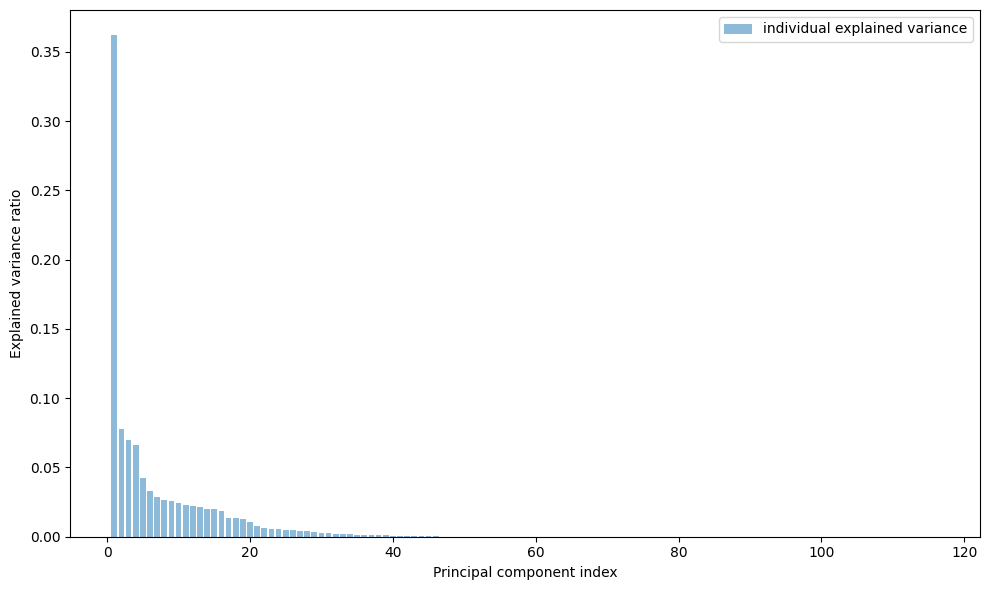

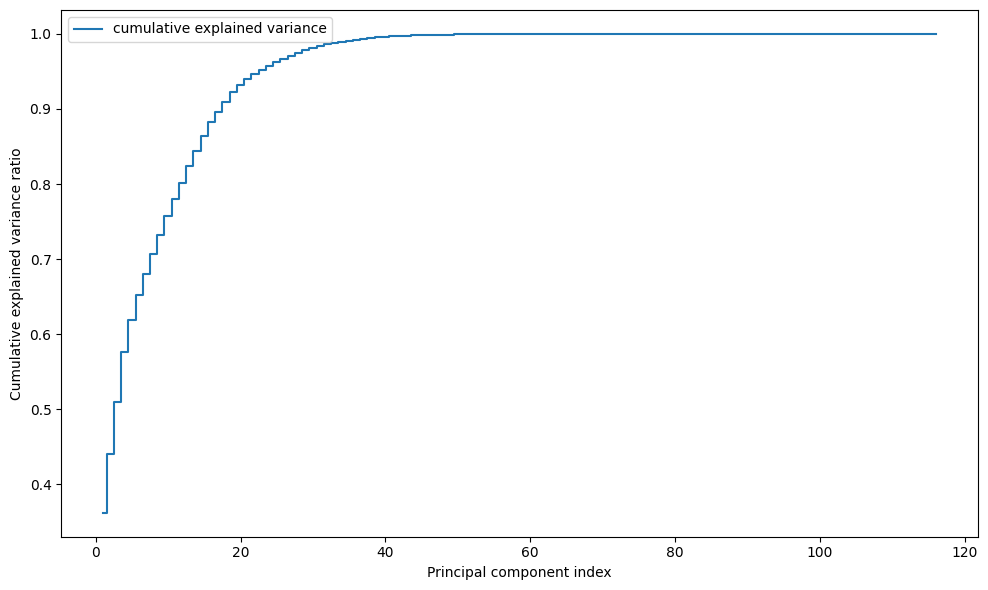

      cos_a_1       cos_b_1       cos_c_1       cos_a_2       cos_b_2   
0    0.152851 -1.256651e-01 -1.527921e-01 -1.513181e-01 -2.270712e-02  \
1   -0.010078  3.796977e-03  9.627035e-03  1.053497e-02 -3.071843e-01   
2   -0.017012  5.798328e-03  1.820681e-02  1.651885e-02 -5.148346e-03   
3   -0.017143 -8.757723e-03  1.481349e-02  1.811656e-02 -2.333200e-02   
4   -0.010180 -1.091623e-01 -3.419260e-03  1.663755e-02  2.387868e-02   
..        ...           ...           ...           ...           ...   
111 -0.000000  7.876661e-16  8.023610e-16  2.049273e-14 -1.899751e-14   
112 -0.000000  2.850674e-16 -1.056123e-15  5.269527e-14  3.377071e-14   
113  0.000000 -1.407687e-16 -3.114390e-15 -3.192805e-14  2.444482e-15   
114 -0.000000  3.669300e-17 -3.011018e-16  2.902720e-14  4.776319e-14   
115  0.000000 -5.308577e-17  4.358930e-15 -7.104804e-14  6.446463e-14   

          cos_c_2       sin_a_1       sin_b_1       sin_c_1       sin_a_2   
0    7.349822e-03  1.530715e-01  8.232835e-02 

In [72]:
#Use PCA to assist with feature selection:

all_input_columns = [

    "cos_a_1",
    "cos_b_1",
    "cos_c_1",
    "cos_a_2",
    "cos_b_2",
    "cos_c_2",

    "sin_a_1",
    "sin_b_1",
    "sin_c_1",
    "sin_a_2",
    "sin_b_2",
    "sin_c_2",



    't',
    'a_enc_1', 'b_enc_1', 'c_enc_1',
    'x_enc_1', 'y_enc_1', 'z_enc_1',
    'a_enc_2', 'b_enc_2', 'c_enc_2',
    'x_enc_2', 'y_enc_2', 'z_enc_2',

    "z_distance", "x_distance", "y_distance",
    "total_dist",
    'a_enc_cos_sim', 'b_enc_cos_sim', 'c_enc_cos_sim',
    'x_enc_diff', 'y_enc_diff', 'z_enc_diff',
    'x_enc_speed_1', 'y_enc_speed_1', 'z_enc_speed_1',
    'x_enc_speed_2', 'y_enc_speed_2', 'z_enc_speed_2',
    'x_enc_acceleration_1', 'y_enc_acceleration_1', 'z_enc_acceleration_1',
    'x_enc_acceleration_2', 'y_enc_acceleration_2', 'z_enc_acceleration_2',
    "a_enc_adjusted_diff", "b_enc_adjusted_diff", "c_enc_adjusted_diff",
    "a_enc_angle_between", "b_enc_angle_between","c_enc_angle_between",


    'a_enc_diff', 'b_enc_diff', 'c_enc_diff',
    'x_enc_jerk_1', 'y_enc_jerk_1', 'z_enc_jerk_1',
    'x_enc_jerk_2', 'y_enc_jerk_2', 'z_enc_jerk_2',
    'a_enc_rate_change_1', 'b_enc_rate_change_1', 'c_enc_rate_change_1',
    'a_enc_rate_change_2', 'b_enc_rate_change_2', 'c_enc_rate_change_2',
    'a_enc_acceleration_1', 'b_enc_acceleration_1', 'c_enc_acceleration_1',
    'a_enc_acceleration_2', 'b_enc_acceleration_2', 'c_enc_acceleration_2',
    'a_enc_jerk_1', 'b_enc_jerk_1', 'c_enc_jerk_1',
    'a_enc_jerk_2', 'b_enc_jerk_2', 'c_enc_jerk_2',

    # # Combined Position and Orientation Features
    'x_enc_a_enc_cos_1', 'x_enc_b_enc_cos_1', 'x_enc_c_enc_cos_1', 'y_enc_a_enc_cos_1', 'y_enc_b_enc_cos_1', 'y_enc_c_enc_cos_1', 'z_enc_a_enc_cos_1', 'z_enc_b_enc_cos_1', 'z_enc_c_enc_cos_1',
    'x_enc_a_enc_sin_1', 'x_enc_b_enc_sin_1', 'x_enc_c_enc_sin_1', 'y_enc_a_enc_sin_1', 'y_enc_b_enc_sin_1', 'y_enc_c_enc_sin_1', 'z_enc_a_enc_sin_1', 'z_enc_b_enc_sin_1', 'z_enc_c_enc_sin_1',
    'x_enc_a_enc_cos_2', 'x_enc_b_enc_cos_2', 'x_enc_c_enc_cos_2', 'y_enc_a_enc_cos_2', 'y_enc_b_enc_cos_2', 'y_enc_c_enc_cos_2', 'z_enc_a_enc_cos_2', 'z_enc_b_enc_cos_2', 'z_enc_c_enc_cos_2',
    'x_enc_a_enc_sin_2', 'x_enc_b_enc_sin_2', 'x_enc_c_enc_sin_2', 'y_enc_a_enc_sin_2', 'y_enc_b_enc_sin_2', 'y_enc_c_enc_sin_2', 'z_enc_a_enc_sin_2', 'z_enc_b_enc_sin_2', 'z_enc_c_enc_sin_2',

]

#Determine which engineered features to use:
X = df_train[all_input_columns]  # Input features

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Apply PCA
pca = PCA(n_components=X.shape[1])
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Cumulative explained variance
cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid', label='cumulative explained variance')
plt.ylabel('Cumulative explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Analyze component makeup
components = pd.DataFrame(pca.components_, columns=X.columns)

print(components)



In [6]:
#Select input and target columns:

input_columns = [
    "z_distance", "x_distance", "y_distance",
    "total_dist",
    'a_enc_cos_sim', 'b_enc_cos_sim', 'c_enc_cos_sim',
    'x_enc_diff', 'y_enc_diff', 'z_enc_diff',
    'x_enc_speed_1', 'y_enc_speed_1', 'z_enc_speed_1',
    'x_enc_speed_2', 'y_enc_speed_2', 'z_enc_speed_2',
    'x_enc_acceleration_1', 'y_enc_acceleration_1', 'z_enc_acceleration_1',
    'x_enc_acceleration_2', 'y_enc_acceleration_2', 'z_enc_acceleration_2',
    "a_enc_adjusted_diff", "b_enc_adjusted_diff", "c_enc_adjusted_diff",
    "a_enc_angle_between", "b_enc_angle_between","c_enc_angle_between",
]
target_columns = ['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2']


In [7]:
#Test/Train Split and Scaling:

# # Split the data into features (X) and targets (y)
X_train, y_train = df_train[input_columns].values, df_train[target_columns].values
X_validation, y_validation = df_validation[input_columns].values, df_validation[target_columns].values
X_test, y_test = df_test[input_columns].values, df_test[target_columns].values

# Preprocess the data (standardization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)


In [77]:

#Use kerastuner for hyperparameter tuning:

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(len(input_columns),)))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    for i in range(hp.Int('num_layers', 2, 5)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu',
                               kernel_regularizer=l2(hp.Choice('l2_value', values=[0.001, 0.0003, 0.0001]))))
        model.add(layers.Dropout(hp.Float('dropout_' + str(i), min_value=0.1, max_value=0.5, default=0.25, step=0.05)))

    model.add(layers.Dense(64, activation='relu', kernel_regularizer=l2(0.0003)))
    model.add(layers.Dense(len(target_columns)))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
                  loss='mae')

    return model

# Instantiate the tuner
tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=1000,
    directory='my_dir',
    project_name='intro_to_kt3')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

# Execute the search
tuner.search(X_train, y_train,
             epochs=10,
             validation_data=(X_validation, y_validation),
             callbacks=[early_stopping])


Trial 1369 Complete [00h 00m 04s]
val_loss: 210.37451171875

Best val_loss So Far: 84.98002624511719
Total elapsed time: 06h 54m 29s

Search: Running Trial #1370

Value             |Best Value So Far |Hyperparameter
3                 |3                 |num_layers
448               |384               |units_0
0.001             |0.0001            |l2_value
0.3               |0.15              |dropout_0
480               |288               |units_1
0.35              |0.45              |dropout_1
0.01              |0.001             |learning_rate
352               |448               |units_2
0.15              |0.3               |dropout_2
256               |224               |units_3
0.5               |0.3               |dropout_3
64                |288               |units_4
0.2               |0.15              |dropout_4
5                 |112               |tuner/epochs
0                 |38                |tuner/initial_epoch
5                 |6                 |tuner/bracket
0    

KeyboardInterrupt: 

In [78]:
#View best hyperparameters:

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(f"Number of Layers: {best_hps.get('num_layers')}")
for i in range(best_hps.get('num_layers')):
    print(f"  Units in layer {i}: {best_hps.get(f'units_{i}')}")
    print(f"  Dropout rate in layer {i}: {best_hps.get(f'dropout_{i}')}")
    if i < best_hps.get('num_layers') - 1:  # No regularization in the last layer
        print(f"  L2 regularization in layer {i}: {best_hps.get(f'l2_value')}")

print(f"Learning Rate: {best_hps.get('learning_rate')}")

Best Hyperparameters:
Number of Layers: 3
  Units in layer 0: 384
  Dropout rate in layer 0: 0.15000000000000002
  L2 regularization in layer 0: 0.0001
  Units in layer 1: 288
  Dropout rate in layer 1: 0.45000000000000007
  L2 regularization in layer 1: 0.0001
  Units in layer 2: 448
  Dropout rate in layer 2: 0.30000000000000004
Learning Rate: 0.001


In [82]:
#Make model directly using best_hps from hyperparameter tuner above

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=1000, batch_size=32,
                    validation_data=(X_validation, y_validation),
                    callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f'Test MAE Loss: {test_loss}')

Epoch 1/1000
628/628 [==============================] - 3s 4ms/step - loss: 454.2795 - val_loss: 259.8129
Epoch 2/1000
628/628 [==============================] - 2s 4ms/step - loss: 248.1660 - val_loss: 203.2346
Epoch 3/1000
628/628 [==============================] - 2s 4ms/step - loss: 222.4680 - val_loss: 191.4719
Epoch 4/1000
628/628 [==============================] - 2s 4ms/step - loss: 206.1053 - val_loss: 167.3982
Epoch 5/1000
628/628 [==============================] - 2s 4ms/step - loss: 193.1601 - val_loss: 156.2023
Epoch 6/1000
628/628 [==============================] - 2s 4ms/step - loss: 180.2622 - val_loss: 144.8721
Epoch 7/1000
628/628 [==============================] - 2s 4ms/step - loss: 167.6771 - val_loss: 139.4017
Epoch 8/1000
628/628 [==============================] - 2s 4ms/step - loss: 158.8113 - val_loss: 124.2144
Epoch 9/1000
628/628 [==============================] - 2s 4ms/step - loss: 151.4741 - val_loss: 121.0280
Epoch 10/1000
628/628 [=======================

In [10]:
#Manually make model using best hyperparameters from prev tuner run:
model = Sequential([
    Dense(384, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(len(input_columns),)),
    Dropout(0.15),
    Dense(288, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.45),
    Dense(448, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.3),
    Dense(len(target_columns)) 
])


# Compile the model with adjusted learning rate
model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')  # Adjust the learning rate as needed

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=1000, batch_size=32,
                    validation_data=(X_validation, y_validation),
                    callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f'Test MAE Loss: {test_loss}')


Epoch 1/1000
628/628 [==============================] - 2s 3ms/step - loss: 471.2213 - val_loss: 269.3086
Epoch 2/1000
628/628 [==============================] - 2s 3ms/step - loss: 264.2915 - val_loss: 207.9875
Epoch 3/1000
628/628 [==============================] - 2s 3ms/step - loss: 231.5687 - val_loss: 188.8140
Epoch 4/1000
628/628 [==============================] - 2s 3ms/step - loss: 220.0951 - val_loss: 186.7061
Epoch 5/1000
628/628 [==============================] - 2s 3ms/step - loss: 209.9521 - val_loss: 172.1919
Epoch 6/1000
628/628 [==============================] - 2s 3ms/step - loss: 200.9744 - val_loss: 160.5653
Epoch 7/1000
628/628 [==============================] - 2s 3ms/step - loss: 192.0712 - val_loss: 165.0806
Epoch 8/1000
628/628 [==============================] - 2s 3ms/step - loss: 182.9007 - val_loss: 152.4052
Epoch 9/1000
628/628 [==============================] - 2s 3ms/step - loss: 175.8906 - val_loss: 143.1523
Epoch 10/1000
628/628 [=======================

In [55]:
# Simpler baseline model for comparison


hyperparams = {
    'max_depth': 3,  
    'n_estimators': 100, 
    'learning_rate': .4,
}

# Create the XGBoost model
model = xgb.XGBRegressor(**hyperparams)

eval_set = [(X_validation, y_validation)]
model.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=10, eval_metric="mae", verbose=True)

# Evaluate the model
y_pred = model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: {test_mae}')


[0]	validation_0-mae:596.72340
[1]	validation_0-mae:370.92192
[2]	validation_0-mae:243.02701
[3]	validation_0-mae:175.95792
[4]	validation_0-mae:143.26980
[5]	validation_0-mae:129.80487
[6]	validation_0-mae:122.93471
[7]	validation_0-mae:120.41914
[8]	validation_0-mae:118.91988
[9]	validation_0-mae:117.84389
[10]	validation_0-mae:117.53927
[11]	validation_0-mae:116.93379
[12]	validation_0-mae:116.62226
[13]	validation_0-mae:115.85714
[14]	validation_0-mae:116.15008


/opt/homebrew/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-mae:114.87145
[16]	validation_0-mae:114.43281
[17]	validation_0-mae:113.73502
[18]	validation_0-mae:114.17085
[19]	validation_0-mae:113.90406
[20]	validation_0-mae:113.84187
[21]	validation_0-mae:112.97929
[22]	validation_0-mae:113.00259
[23]	validation_0-mae:113.13362
[24]	validation_0-mae:112.54452
[25]	validation_0-mae:112.23261
[26]	validation_0-mae:112.07864
[27]	validation_0-mae:111.84200
[28]	validation_0-mae:111.66298
[29]	validation_0-mae:111.49436
[30]	validation_0-mae:111.94123
[31]	validation_0-mae:112.04284
[32]	validation_0-mae:110.88321
[33]	validation_0-mae:111.39335
[34]	validation_0-mae:110.98912
[35]	validation_0-mae:110.94684
[36]	validation_0-mae:111.02378
[37]	validation_0-mae:111.00310
[38]	validation_0-mae:110.76965
[39]	validation_0-mae:110.76384
[40]	validation_0-mae:110.46568
[41]	validation_0-mae:109.98455
[42]	validation_0-mae:110.10586
[43]	validation_0-mae:109.50603
[44]	validation_0-mae:109.29038
[45]	validation_0-mae:109.52198
[46]	val

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/homebrew/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in const

Best hyperparameters:
 {'learning_rate': 0.15981604753894502, 'max_depth': 7, 'n_estimators': 64}
Test MAE: 153.52785683297543


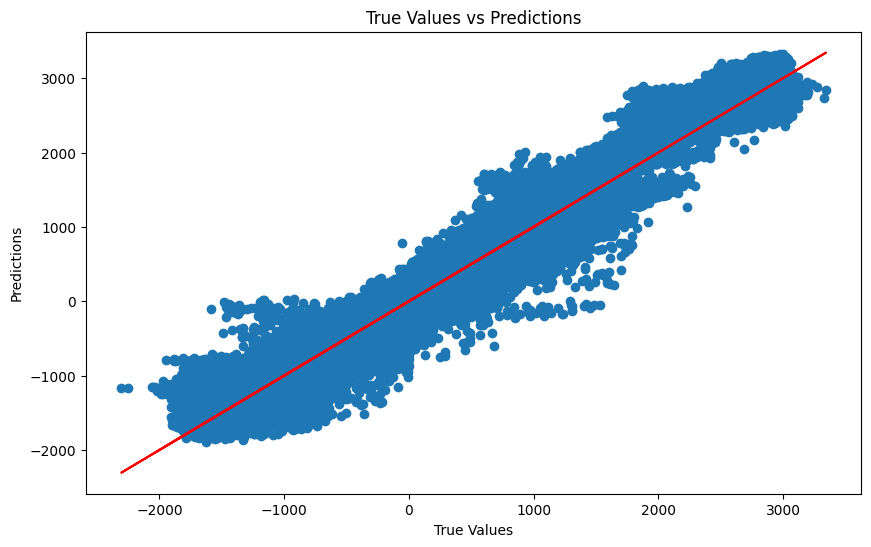

In [63]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
import scipy.stats as stats

# Define a range of hyperparameters for tuning
param_dist = {
    'max_depth': stats.randint(3, 10),
    'n_estimators': stats.randint(50, 200),
    'learning_rate': stats.uniform(0.01, 0.4),
    # Add other hyperparameters here
}

# Create the XGBoost regressor
xgb_model = xgb.XGBRegressor()

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, 
                                   n_iter=10, scoring='neg_mean_absolute_error', cv=3, verbose=1, random_state=42)

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_validation, y_validation)], verbose=False)

# Get the best parameters
best_hyperparams = random_search.best_params_
print("Best hyperparameters:\n", best_hyperparams)

# Create model with the best parameters
best_model = xgb.XGBRegressor(**best_hyperparams)

# Fit the model
best_model.fit(X_train, y_train)

# Evaluate the model
y_pred = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: {test_mae}')

# Plotting predictions against actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test, color='red')  # A diagonal line representing perfect predictions
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.show()


Test MAE: 249.76258821501028


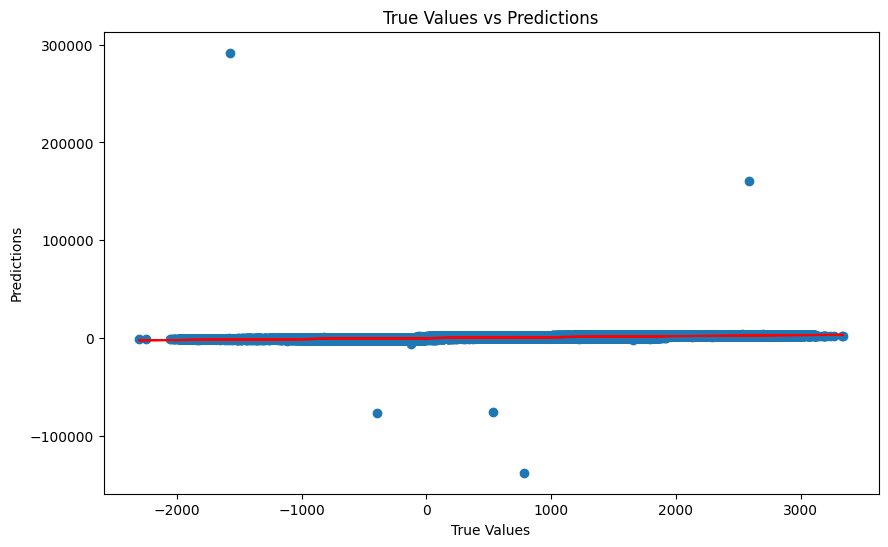

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [62]:

#Simple linear regression for baseline model comparison:

# Create the Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: {test_mae}')

# Plotting predictions against actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test, color='red')  # A diagonal line representing perfect predictions
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.show()


## Results:
The best model in terms of MAE was the RNN with MAE of 128.9 (baseline linear regression had MAE of 249.6, XGBoost: MAE of 153.5). 
How satisfactory this performance is depends on the application. For instance, if we were just trying to determine whether the metal will reach its fracture point for a given run then this might be sufficient.
I would provide more in depth analysis with more time / background info on this problem.